In [40]:
import os
import numpy as np
import pandas as pd

from pmagpy import ipmag, pmag
from kneed import KneeLocator
from scipy.interpolate import UnivariateSpline
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns

from vgptools.utils_APWPs import running_mean_APWP_shape 

## 1. Compile the directions / VGPs

In [25]:
current_path = os.getcwd()
data_path_VGP = current_path + '/data/vgp_database'

In [15]:
df_filtered_vgps = pd.read_csv(current_path +'/data/df_vgps_filtered.csv')

### The following block iterates through different window widths (it takes ~20 min)

This process involves iterating through different window widths, ranging from 5 million years to 45 million years, and dividing the original dataset into two subgroups, one for training and one for validation. We then run a Moving Average (MA) on the training subgroup and in the validations group. The time-varying distance between the Moving averages on training and validation sets is calculated and we store its mean and standard deviation values. The underlying idea is to train the model with the training subgroup using a certain window width and then evaluate its performance on the validation subgroup with the same window width. This iteration is done for different window widths to find the optimal window size.

In [46]:
%%time

min_age = 0
max_age = 55
step = 1
window_lengths = range(5,45,1) 

df_ensemble = pd.DataFrame(columns = ['step_size','window_lenght','n_training','mean_distance','std_distance'])

    
for window in window_lengths:

    for i in range(50):

        df_tmp = pd.DataFrame()

        train, test = train_test_split(df_filtered_vgps, test_size=0.5)  # 0.3      

        mean_distances = []
        std_distances = []

        # train_ = get_vgps_sampling_from_direction(train)
        # test_ = get_vgps_sampling_from_direction(test)

        RM_train_ = running_mean_APWP_shape(train, 'vgp_lon_SH', 'vgp_lat_SH', 'mean_age', window, step, max_age, min_age)
        RM_test_ = running_mean_APWP_shape(test, 'vgp_lon_SH', 'vgp_lat_SH', 'mean_age', window, step, max_age, min_age)

        distances = []

        for t in RM_train_.age.unique():

            df_train = RM_train_[RM_train_['age']==t]
            df_test = RM_test_[RM_test_['age']==t]

            try:
                gcd = pmag.angle([df_train['plon'].iat[0], df_train['plat'].iat[0]],
                                 [df_test['plon'].iat[0], df_test['plat'].iat[0]])
            except:
                continue

            distances.append(gcd)

        mean_distances.append(np.array(distances).mean())
        std_distances.append(np.array(distances).std())

        df_ensemble.loc[len(df_ensemble)] = [step, window, i, np.array(mean_distances).mean(), np.array(std_distances).mean()]

df_ensemble.head()

CPU times: user 26min 29s, sys: 6.41 s, total: 26min 35s
Wall time: 26min 38s


,step_size,window_lenght,n_training,mean_distance,std_distance
0,1.0,5.0,0.0,4.917367,2.581478
1,1.0,5.0,1.0,4.231081,2.241876
2,1.0,5.0,2.0,4.485377,2.678032
3,1.0,5.0,3.0,3.583621,2.383466
4,1.0,5.0,4.0,3.472796,2.037165


In [47]:
df = df_ensemble.copy()

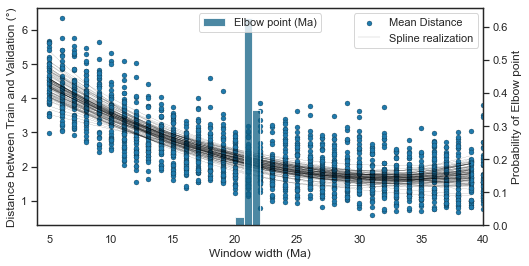

In [49]:
sns.reset_orig
fig,ax = plt.subplots(figsize=(8,4))
sns.set_theme(style="white") 
ax.set_ylabel('Distance between Train and Validation (°)')
ax.set_xlabel('Window width (Ma)')    

# Plot the 
ax.scatter(x=df["window_lenght"].to_list(), y=df["mean_distance"].to_list(), 
               color = '#207AAC', s = 25 , edgecolor = 'black', linewidth=0.2, label = 'Mean Distance')

knees=[]
for i in range(100):
    
    df_grouped = df.groupby('window_lenght')
    x = range(5,40)
    
    y = [df_grouped.get_group(x_i)
                   .sample(n = 1 , replace=True)
                   .mean_distance.median() for x_i in x]   
    
    # y = [df_grouped.get_group(x_i).sample(n = 1, replace=True).mean_distance for x_i in x]   
    
    s = UnivariateSpline(x, np.array(y), k=2)    
   
    ax.plot(x, s(x),color = 'black',linewidth=0.1)
    
    kneedle = KneeLocator(x, s(x),  S = 10, interp_method="interp1d",
                      curve="convex", direction="decreasing")

    knees.append(kneedle.knee) 
df_knees = pd.DataFrame({'knees':knees})

ax.plot(x, s(x),color = 'black',linewidth=0.1, label = 'Spline realization')    

          
ax2=ax.twinx()              
ax2.set_xlim(4,40)
ax2.set_ylabel('Probability of Elbow point')


sns.histplot(data = df_knees, x = 'knees', stat='probability', color='#106084', ax = ax2, bins =3, label = 'Elbow point (Ma)') #, label = 'Elbow point Probability')
ax.legend(loc="upper right")
ax2.legend(loc="upper center")
# plt.savefig(current_path + '/figures/cross_validation/graph.svg', dpi =600, bbox_inches='tight')

# Optimal elbow point (i.e. Window width)

In [53]:
print(f"The optimal elbow point is : {df_knees.knees.median()} (Ma)")

The optimal elbow point is : 21.0 (Ma)
